## 实例对象的创建

创建实例对象有两种方式：



通过 Python / C API 创建，只适用于内置类对象的实例对象；

通过调用类型对象创建，适用于所有的实例对象；


In [1]:
lst1 = []
lst2 = list()

**这两种都是合法的，但 lst1 指向的列表是通过 Python / C API 创建的，lst2 指向的列表是通过调用类型对象创建的。**



在工作中，更推荐使用 Python / C API 创建。因为内置类对象的实例对象，在底层是预先定义好的，结构体内部有哪些字段已经写死了，直接创建就行了，所以**它的速度比调用类型对象要快**。而解释器也能区分出实例对象的种类，比如看到 [] 时，就知道是列表；看到 () 时，就知道是元组；看到 {} 时，就知道是字典。



而通过 Python / C API 创建虽然更快，但这是内置类对象的实例对象才享有的特权。**对于自定义类而言，想创建其实例对象，只能通过调用类型对象的方式。**这是显而易见的，因为解释器不可能把我们自定义类的实例对象在底层预先定义好。



下面就以自定义类对象为例，看看实例对象是如何创建的。

In [2]:
class Girl:
    
    def __init__(self, name, age):
        self.name = name
        self.age = age 

g = Girl("satori", 16)

字节码执行完毕之后，模块的名字空间如下：
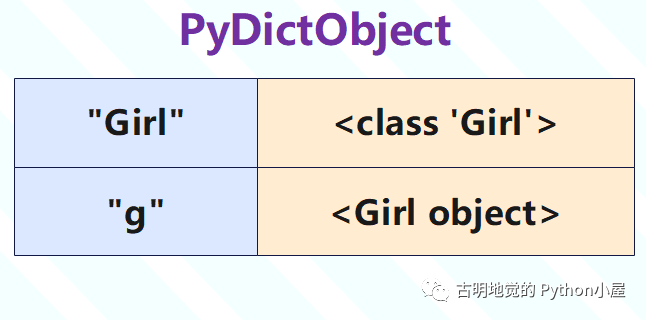

调用对象，本质上是执行对应类对象的 \__call__。



因此，**在Python里面调用类对象会执行 type.\__call__，而在 \__call__里面会执行类对象的 \__new__创建实例对象，然后执行 \__init__（如果存在）给实例绑定属性，最后返回。**



而对应虚拟机的层面，在CALL_FUNCTION中，显然会执行 &PyType_Type 的 tp_call，而在 tp_call 中会执行类对象的 tp_new 创建实例对象，然后执行 tp_init（如果存在）给实例绑定属性，最后返回。



但需要注意的是，Girl 这个类本身是没有 \__new__ 的。在创建它时，虚拟机会调用 PyType_Ready 进行初始化，而其中一项动作就是继承基类，所以 Girl.\__new__ 实际上就是 object.\__new__。

In [4]:
class Girl:

    def __init__(self, name, age):
        self.name = name
        self.age = age

print(Girl.__new__ is object.__new__)

True


因此创建类对象和创建实例对象的不同之处就在于 tp_new 不同。

**创建类对象，虚拟机调用的是 type_new；创建实例对象，虚拟机则调用 object_new。至于字节码指令，两者是一致的。**

总结来看，类对象创建实例对象的两个步骤：

instance = cls.__new__(cls, *args, ** kwargs)

cls.__init__(instance, *args, ** kwargs)，如果一个类没有 __init__，那么就没有这一步，比如 tuple

## 实例对象的属性访问

之前在讨论名字空间的时候提到，**在Python中，形如 x.y 样式的表达式被称之为属性引用，其中 x 指向某个对象，y 为对象的某个属性**。并且这个属性可以是很多种，比如：整数、字符串、函数、类、甚至是模块等等。



那么下面来看看虚拟机是怎么实现属性引用的？



### 属性引用

In [5]:
class Girl:
    
    def __init__(self):
        self.name = "satori"
        self.age = 16
        
    def get_info(self):
        return f"name: {self.name}, age: {self.age}"
    
g = Girl()
name = g.name
g.get_info()

'name: satori, age: 16'

**简单了解一下获取属性的流程：**
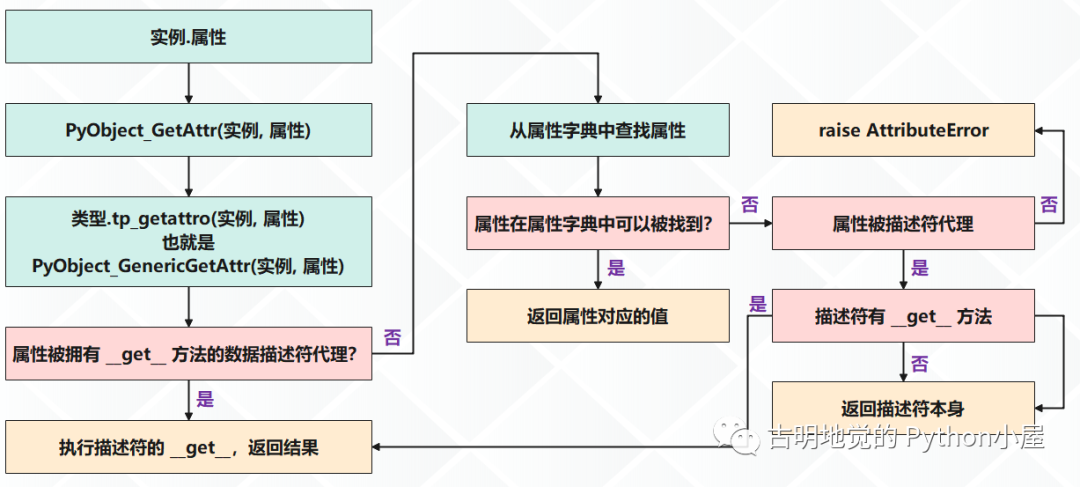

In [6]:
class Descriptor:

    def __set__(self, instance, value):
        print("__set__")

class B:

    name = Descriptor()

b = B()
# b 的属性字典没有 name，描述符也没有 __get__
# 那么这个时候会返回描述符本身
print(b.name)  

# 此时属性字典里面有 name 了
b.__dict__["name"] = "古明地觉"
# 由于 name 是被数据描述符代理的
# 按理说获取属性时会执行数据描述符的 __get__
# 但是这个数据描述符压根没有 __get__
# 因此还是会从属性字典中查找
print(b.name)  

古明地觉


### 函数变身

下面来讨论一下参数 self。


In [7]:
class Girl:

    def __init__(self, name, age):
        self.name = name
        self.age = age

    def get_info(self):
        return f"name = {self.name}, age = {self.age}"

g = Girl("satori", 16)
res = g.get_info()
print(res)

name = satori, age = 16


**我们在调用 g.get_info 的时候，并没有给 self 传递参数，那么 self 到底是不是一个真正有效的参数呢**？还是说它仅仅只是一个语法意义上的占位符而已？



不用想，**self 肯定是货真价实的参数，只不过自动帮你传递了**。根据使用 Python 的经验，我们知道第一个参数就是实例本身。那么这是怎么实现的呢？想要弄清这一点，还是要从字节码入手。而调用方法的字节码是 CALL_METHOD，那么玄机就隐藏在这里面。

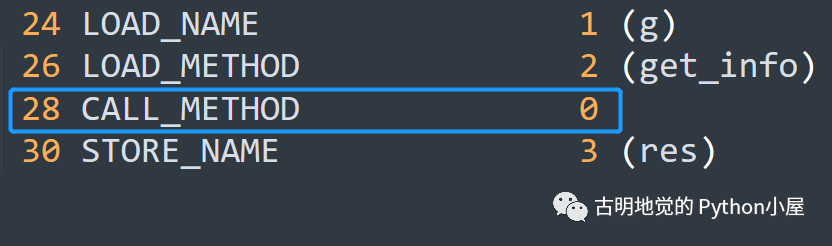

调用时的操作数是 0，表示不需要传递参数。注意：这里说的不需要传递参数，指的是不需要我们手动传递。

通过对比CALL_METHOD和 CALL_FUNCTION 的源码我们可以知道，这两者都调用了call_function，但是传递的参数不一样。如果是类调用，那么 CALL_METHOD和 CALL_FUNCTION是等价的；但如果是实例调用，CALL_METHOD 的第三个参数是 oparg + 1，CALL_FUNCTION 则是 oparg。


但是这还不足以支持我们找出问题所在。其实在剖析函数的时候，我们放过了函数的类型对象 PyFunction_Type。而在这个 PyFunction_Type 里面，隐藏着一个惊天大秘密。


我们发现 tp_descr_get 被设置成了 func_descr_get，这意味着 Girl.get_info 是一个描述符。而实例 g 的属性字典中没有 get_info，那么 g.get_info 的返回值将会被描述符改变。



因此 func_descr_get(Girl.f, girl, Girl) 就是 g.get_info 的返回结果。

函数对应的结构体是 PyFunctionObject，那么 PyMethodObject 是啥应该不需要我说了，显然就是方法对应的结构体。


**所以类里面的定义的就是单纯的函数，通过类去调用的话，和调用一个普通函数并无区别。但是实例调用就不一样了，实例在拿到类的成员函数时，会先调用 PyMethod_New 将函数包装成方法，然后再对方法进行调用。**

In [8]:
class Girl:

    def __init__(self, name, age):
        self.name = name
        self.age = age

    def get_info(self):
        return f"name = {self.name}, age = {self.age}"

g = Girl("satori", 16)
print(Girl.get_info.__class__)
print(g.get_info.__class__)

<class 'function'>
<class 'method'>


在获取 get_info 时，会发现它被描述符代理了，而描述符就是函数本身。因为类型对象 PyFunction_Type 实现了 tp_descr_get、即 \__get__，所以它的实例对象（函数）本质上就是个描述符。



因此无论是类还是实例，在调用时都会执行 func_descr_get。如果是类调用，那么实例 obj 为空，于是会将成员函数直接返回，因此类调用的就是函数本身。



如果是实例调用，则执行 PyMethod_New，将 PyFunctionObject 包装成 PyMethodObject，然后调用。因此，实例调用的是方法。



**所以不管是类还是实例，获取成员函数都会走描述符的 func_descr_get，在里面会判断是类获取还是实例获取。如果是类获取，会直接返回函数本身；如果是实例获取，则通过PyMethod_New将函数和实例绑定起来得到方法，这个过程称为成员函数的绑定。**
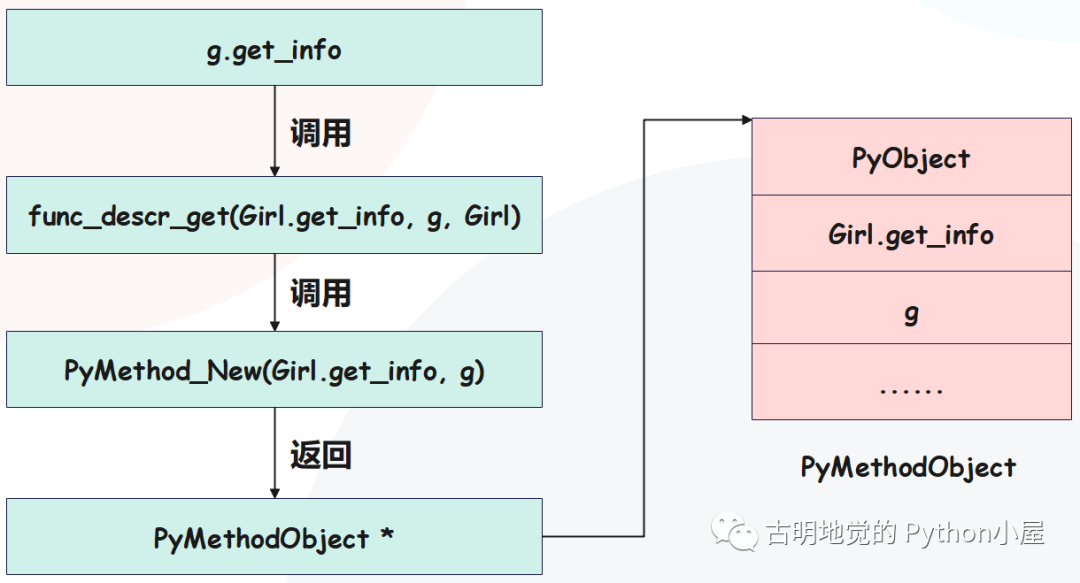

当然，调用方法本质上还是调用方法里面 im_func，也就是函数;只不过会处理自动传参的逻辑，将内部的 im_self（实例）和我们传递的参数组合起来(如果没有传参，那么只有一个 im_self)，然后整体传递给 im_func。

